In [1]:
import numpy as np
import torch
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from scipy.special import expit as sigmoid

In [2]:
X, y = make_moons(200,noise=0.5, random_state=1)
y = y.reshape(-1, 1)

m = len(X)
print(m)

200


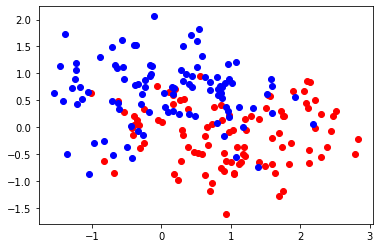

In [3]:
plt.figure(figsize=(6, 4))
plt.plot(X[:,0][y[:, 0]==1], X[:,1][y[:, 0]==1],'o', color='r')
plt.plot(X[:,0][y[:, 0]==0], X[:,1][y[:, 0]==0],'o', color='b')

In [4]:
def RBFkernel(X1, X2, param):
   

    sqdist = np.sum(X1 ** 2, 1).reshape(-1, 1) + np.sum(X2 ** 2, 1) - 2 * np.dot(X1, X2.T)
    return param[1] ** 2 * np.exp(-0.5 / param[0] ** 2 * sqdist)

In [5]:
def Cal_K(X, param, diag_only=False, sigma=1e-5):
   # sigma model noise
    if diag_only:
       
        return param[1] ** 2 + sigma
    else:
        return RBFkernel(X, X, param) + sigma * np.eye(X.shape[0])

def Cal_W(a):
 
    x = sigmoid(a) * (1 - sigmoid(a))
    return np.diag(x.ravel())

In [6]:

def posterior_mode(X, t, K_a, iter_max=10, bound=1e-9):
   
    a_hat = np.zeros_like(t)
    I = np.eye(X.shape[0])

    for i in range(iter_max):
        W = Cal_W(a_hat)
        Q_inv = np.linalg.inv(I + W @ K_a)
        a_hat_new = (K_a @ Q_inv).dot(t - sigmoid(a_hat) + W.dot(a_hat))
        a_hat_diff = np.abs(a_hat_new - a_hat)
        a_hat = a_hat_new

        if not np.any(a_hat_diff > bound):
            break

    return a_hat

In [7]:
def neg_log_l(X, t):
    
    t = t.ravel()

    def nll(param):
        K_a = Cal_K(X, param)
        K_a_inv = np.linalg.inv(K_a)

        a_hat = posterior_mode(X, t, K_a).ravel()
        W = Cal_W(a_hat)

        ll = - 0.5 * a_hat.T.dot(K_a_inv).dot(a_hat) \
             - 0.5 * np.linalg.slogdet(K_a)[1] \
             - 0.5 * np.linalg.slogdet(W + K_a_inv)[1] \
             + t.dot(a_hat) - np.sum(np.log(1.0 + np.exp(a_hat)))

        return -ll

    return nll

In [8]:
#maximizing log likelihood is same as minimize negitive log likelihood function to obtain optimal kernel param
#inital value of param [1,1]

opt = minimize(neg_log_l(X, y), [1, 1],
               bounds=((1e-3, None), (1e-3, None)),
               method='BFGS')

param = opt.x

print(f'Optimized Kernel parameters parameter 1 = [{param[0]:.4f}] and parameter 2 ={param[1]:.4f}], negative log likelihood = {opt.fun:.3f}')

C:\Users\tashi\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:533: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


Optimized Kernel parameters parameter 1 = [1.3519] and parameter 2 =3.3789], negative log likelihood = 93.434


In [14]:
def predict_a(X_test, X, t, param):
    
    K_a = Cal_K(X, param)
    K_star = RBFkernel(X, X_test, param)
    a_h = posterior_mode(X, t, K_a)

    W_inv = np.linalg.inv(Cal_W(a_h))
    R_inv = np.linalg.inv(W_inv + K_a)

    a_test_mu = K_star.T.dot(t - sigmoid(a_h))
    #calculate variance only not covariance 
    a_test_var = Cal_K(X_test, param, diag_only=True) - np.sum((R_inv @ K_star) * K_star, axis=0).reshape(-1, 1)

    return a_test_mu, a_test_var


def predict_point(X_test, X, t, param):
    
    a_mean, a_var = predict_a(X_test, X, t, param)
    temp = 1.0 / np.sqrt(1.0 + np.pi * a_var / 8)
    return sigmoid(temp * a_mean)

In [15]:
grid_x, grid_y = np.mgrid[-4:4:200j, -4:4:200j]
grid = np.stack([grid_x, grid_y], axis=-1)

Text(0.5, 1.0, 'Class 1 prediction probability')

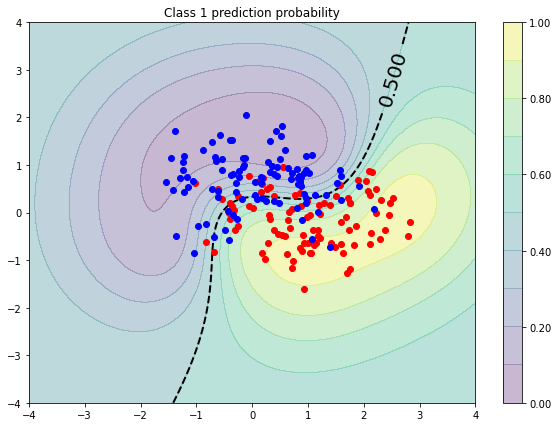

In [20]:
pt_test = predict_point(grid.reshape(-1, 2), X, y, param).reshape(*grid_x.shape)

plt.figure(figsize=(10, 7))
plt.contourf(grid_x, grid_y, pt_test, alpha=0.3, levels=np.linspace(0, 1, 11))
plt.colorbar(format='%.2f')


cs = plt.contour(grid_x, grid_y, pt_test, levels=[0.5], colors='black', linestyles='dashed', linewidths=2)
plt.clabel(cs, fontsize=20)

plt.plot(X[:,0][y[:, 0]==1], X[:,1][y[:, 0]==1],'o', color='r')
plt.plot(X[:,0][y[:, 0]==0], X[:,1][y[:, 0]==0],'o', color='b')
plt.title('Class 1 prediction probability')

Text(0.5, 1.0, 'Uncertainty')

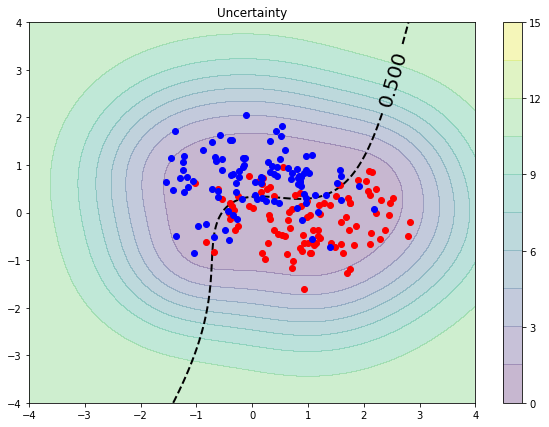

In [25]:
a_test = predict_a(grid.reshape(-1, 2), X, y, param)[1].reshape(*grid_x.shape)

plt.figure(figsize=(10, 7))
plt.contourf(grid_x, grid_y, a_test, alpha=0.3, levels=np.linspace(0, 15, 11))
plt.colorbar()

cs = plt.contour(grid_x, grid_y, pt_test, levels=[0.5], colors='black', linestyles='dashed', linewidths=2)
plt.clabel(cs, fontsize=20)

plt.plot(X[:,0][y[:, 0]==1], X[:,1][y[:, 0]==1],'o', color='r')
plt.plot(X[:,0][y[:, 0]==0], X[:,1][y[:, 0]==0],'o', color='b')
plt.title('Uncertainty')